In [1]:
import time
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import dgl
import networkx as nx
import torch
import torch.nn as nn

import utils
from gsp_utils.baselines_archs import GCNN_2L
from gsp_utils.baselines_models import NodeClassModel, GF_NodeClassModel
from gsp_utils.data import normalize_gso
from src.arch import GFGCN, GFGCNLayer, GFGCN_noh_Layer, GFGCN_Spows

SEED = 15
# PATH = 'results/diff_filters/'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(SEED)

cuda:1


In [2]:
# Auxiliary functions
def summary_table(acc, index_name):
    mean_accs = acc.mean(axis=1)
    med_accs = np.median(acc, axis=1)
    std_accs = acc.std(axis=1)
    return DataFrame(np.vstack((mean_accs, med_accs, std_accs)).T, columns=['mean accs', 'med', 'std'], index=index_name)

In [3]:
# Dataset must be from DGL
dataset_name = 'CornellDataset'

A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device,
                                                     verb=True)
N = A.shape[0]

Dataset: CornellDataset
Number of nodes: 183
Number of features: 1703
Shape of signals: torch.Size([183, 1703])
Number of classes: 5
Norm of A: 17.262676239013672
Max value of A: 1.0
Proportion of validation data: 0.32
Proportion of test data: 0.20
Node homophily: 0.11
Edge homophily: 0.13


# Without normalizing the GSO

In [4]:
# BEST PARAMETERS
## Reaining params
N_RUNS = 25
N_EPOCHS = 200  # 500
LR = .05
WD = .01
DROPOUT = 0

# BEST PARAMETERS
## Architecture params
N_LAYERS = 2
K = 3
HID_DIM = 50

## Model params
h0 = 1  # 1
NORM = False

IN_DIM = feat.shape[1]
OUT_DIM = n_class

ACT = nn.ELU()  # nn.ReLU()
LAST_ACT = nn.Softmax(dim=1)
LOSS_FN = nn.NLLLoss() #nn.CrossEntropyLoss()

## Plotting eval/test acc/loss

In [5]:
# Parameters
epochs = N_EPOCHS
epochs_h = 1
epochs_W = 1
lr = LR
wd = WD
drop = 0
L = N_LAYERS
K_aux = K
hid_dim = HID_DIM
h0_aux = 1  # 1
norm = False
act = ACT
lact = LAST_ACT
loss = LOSS_FN

# Create model
arch = GFGCN(IN_DIM, hid_dim, OUT_DIM, L, K_aux, act=act, last_act=lact,
             dropout=drop, init_h0=h0_aux)
S = torch.Tensor(A).to(device)
model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
loss, acc = model.train(feat, labels, epochs, lr, wd, epochs_h=epochs_h, epochs_W=epochs_W)

idx_max_acc = np.argmax(acc["val"])
print(f'Best val acc: {acc["val"][idx_max_acc]:.3f}')
print(f'Test acc at best val: {acc["test"][idx_max_acc]:.3f}')
print(f'Best test acc: {np.max(acc["test"]):.3f}')

Best val acc: 0.864
Test acc at best val: 0.784
Best test acc: 0.865


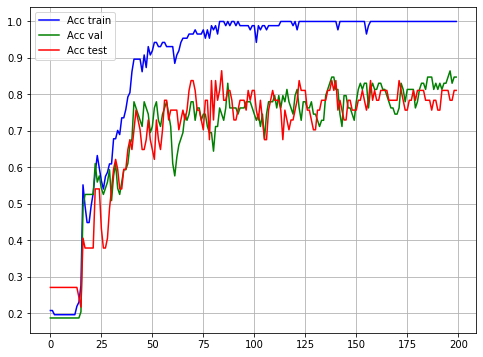

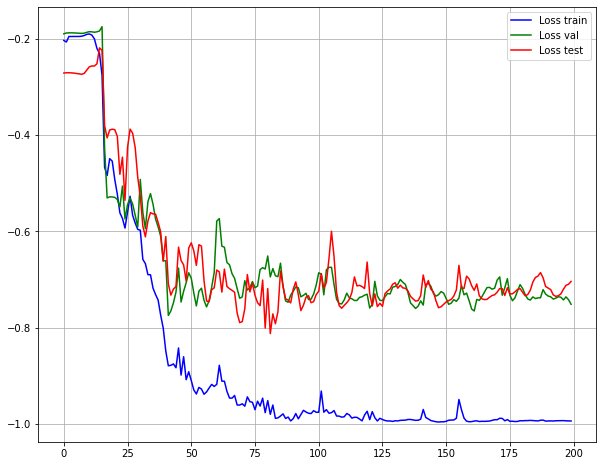

In [6]:
# Plot
plt.figure(figsize=[8,6])
plt.plot(acc['train'], 'b-', label='Acc train')
plt.plot(acc['val'], 'g-', label='Acc val')
plt.plot(acc['test'], 'r-', label='Acc test')
plt.grid()
plt.legend()

plt.figure(figsize=[10,8])
plt.plot(loss['train'], 'b-', label='Loss train')
plt.plot(loss['val'], 'g-', label='Loss val')
plt.plot(loss['test'], 'r-', label='Loss test')
plt.grid()
plt.legend()

## Training paramerters

In [12]:
EXPS = [
        # {'epochs': 200, 'lr': .5, 'wd': 5e-4, 'drop': 0},
        {'epochs': 200, 'lr': .1, 'wd': 5e-4, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 5e-4, 'drop': 0},
        # {'epochs': 200, 'lr': .01, 'wd': 5e-4, 'drop': 0},
        # {'epochs': 200, 'lr': .001, 'wd': 5e-4, 'drop': 0},
        
        {'epochs': 200, 'lr': .05, 'wd': 1e-3, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 5e-2, 'drop': 0},

        {'epochs': 200, 'lr': .1, 'wd': 1e-3, 'drop': 0},
        {'epochs': 200, 'lr': .1, 'wd': 1e-2, 'drop': 0},
        {'epochs': 200, 'lr': .1, 'wd': 5e-2, 'drop': 0},
        
        {'epochs': 500, 'lr': .1, 'wd': 1e-2, 'drop': 0},
        {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        {'epochs': 500, 'lr': .01, 'wd': 1e-2, 'drop': 0},

        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .25},
        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        # {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .75},
        {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .25},
        {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        {'epochs': 750, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        {'epochs': 750, 'lr': .05, 'wd': 1e-2, 'drop': .75},
        # {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .75},
        ]

best_accs1 = np.zeros((len(EXPS), N_RUNS))
best_val_accs1 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                     dropout=exp['drop'], init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'])

        best_accs1[j,i] = np.max(acc["test"])
        best_val_accs1[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}: {best_val_accs1[j,i]:.3f} ({best_accs1[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}' for exp in EXPS]
table_over1 = summary_table(best_accs1, index_name)
table1 = summary_table(best_val_accs1, index_name)



-1: 200-0.1-0.0005-0: 0.541 (0.595)
-1: 200-0.05-0.0005-0: 0.459 (0.486)
-1: 200-0.05-0.001-0: 0.703 (0.730)


In [ ]:
table1


,mean accs,med,std
200-0.5-0.0005-0,0.438919,0.405405,0.086918
200-0.1-0.0005-0,0.531892,0.513514,0.101045
200-0.05-0.0005-0,0.576216,0.567568,0.120073
200-0.01-0.0005-0,0.397838,0.405405,0.090939
200-0.001-0.0005-0,0.315676,0.324324,0.077853
200-0.05-0.001-0,0.616216,0.675676,0.138023
200-0.05-0.01-0,0.754595,0.783784,0.070858
200-0.05-0.05-0,0.621622,0.540541,0.182187
200-0.1-0.001-0,0.585946,0.567568,0.097213
200-0.1-0.01-0,0.715676,0.702703,0.053576


In [ ]:
table_over1

,mean accs,med,std
200-0.5-0.0005-0,0.471351,0.513514,0.086851
200-0.1-0.0005-0,0.577297,0.540541,0.095442
200-0.05-0.0005-0,0.647568,0.648649,0.125489
200-0.01-0.0005-0,0.431351,0.432432,0.083907
200-0.001-0.0005-0,0.344865,0.351351,0.073831
200-0.05-0.001-0,0.676757,0.729730,0.151251
200-0.05-0.01-0,0.860541,0.864865,0.035594
200-0.05-0.05-0,0.669189,0.540541,0.198207
200-0.1-0.001-0,0.632432,0.621622,0.104536
200-0.1-0.01-0,0.820541,0.837838,0.055061


## Model params

In [ ]:
# h0, norm (norm, not norm, norm H), sep vs joint training, optimizers iters (W vs h)
EXPS = [
        {'h0': .001, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': .01, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': .1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        
        {'h0': .01, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},

        {'h0': 1, 'epochs': 200, 'epochs_h': 5, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 5, 'alt': True},

        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 5, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 5, 'alt': True},
        
        {'h0': .01, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 50, 'epochs_h': 50, 'epochs_W': 50, 'alt': True},
    ]


best_accs2 = np.zeros((len(EXPS), N_RUNS))
best_val_accs2 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=exp['h0'])
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        if not exp['alt']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD)
        else:
            model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD, epochs_h=exp['epochs_h'],
                                 epochs_W=exp['epochs_W'])

        best_accs2[j,i] = np.max(acc["test"])
        best_val_accs2[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["h0"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}: {best_val_accs2[j,i]:.3f} ({best_accs2[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["h0"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}' for exp in EXPS]
table_over2 = summary_table(best_accs2, index_name)
table2 = summary_table(best_val_accs2, index_name)

-1: 0.001-1-1-True: 0.757 (0.838)
-1: 0.01-1-1-True: 0.811 (0.865)
-1: 0.1-1-1-True: 0.838 (0.865)
-1: 1-1-1-True: 0.838 (0.865)
-1: 0.01-1-1-False: 0.838 (0.865)
-1: 1-1-1-False: 0.703 (0.892)
-1: 1-5-1-True: 0.730 (0.838)
-1: 1-10-1-True: 0.757 (0.865)
-1: 1-25-1-True: 0.784 (0.865)
-1: 1-25-5-True: 0.730 (0.865)
-1: 1-1-5-True: 0.811 (0.838)
-1: 1-1-10-True: 0.703 (0.838)
-1: 1-1-25-True: 0.784 (0.865)
-1: 1-25-5-True: 0.757 (0.865)
-1: 0.01-10-10-True: 0.811 (0.865)
-1: 1-10-10-True: 0.784 (0.838)
-1: 1-25-25-True: 0.784 (0.865)
-1: 1-50-50-True: 0.865 (0.865)
-2: 0.001-1-1-True: 0.757 (0.892)
-2: 0.01-1-1-True: 0.811 (0.838)
-2: 0.1-1-1-True: 0.757 (0.838)
-2: 1-1-1-True: 0.784 (0.892)
-2: 0.01-1-1-False: 0.838 (0.838)
-2: 1-1-1-False: 0.757 (0.865)
-2: 1-5-1-True: 0.784 (0.865)
-2: 1-10-1-True: 0.757 (0.865)
-2: 1-25-1-True: 0.703 (0.892)
-2: 1-25-5-True: 0.784 (0.865)
-2: 1-1-5-True: 0.784 (0.865)
-2: 1-1-10-True: 0.811 (0.865)
-2: 1-1-25-True: 0.703 (0.838)
-2: 1-25-5-True: 0.7

KeyboardInterrupt: 

In [ ]:
table2

,mean accs,med,std
200-0.001-1-1-True,0.769730,0.783784,0.052474
200-0.01-1-1-True,0.756757,0.756757,0.084088
200-0.1-1-1-True,0.767568,0.783784,0.068374
200-1-1-1-True,0.766486,0.783784,0.081218
200-0.01-1-1-False,0.758919,0.783784,0.079413
200-1-1-1-False,0.777297,0.783784,0.039927
200-1-5-1-True,0.771892,0.783784,0.029685
200-1-10-1-True,0.767568,0.756757,0.035855
200-1-25-1-True,0.767568,0.783784,0.046499
200-1-25-5-True,0.776216,0.783784,0.039367


In [ ]:
table_over2

,mean accs,med,std
200-0.001-1-1-True,0.869189,0.864865,0.023784
200-0.01-1-1-True,0.841081,0.864865,0.069358
200-0.1-1-1-True,0.851892,0.864865,0.067132
200-1-1-1-True,0.849730,0.864865,0.067979
200-0.01-1-1-False,0.848649,0.864865,0.065760
200-1-1-1-False,0.863784,0.864865,0.019459
200-1-5-1-True,0.865946,0.864865,0.017895
200-1-10-1-True,0.874595,0.864865,0.018537
200-1-25-1-True,0.868108,0.864865,0.019218
200-1-25-5-True,0.870270,0.864865,0.018725


## Architecture design

In [ ]:
# layers, filter order, weightd
EXPS = [{'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        {'L': 2, 'K': 4, 'hid_dim': 16},

        {'L': 3, 'K': 2, 'hid_dim': 16},
        {'L': 4, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 3, 'hid_dim': 16},
        {'L': 4, 'K': 3, 'hid_dim': 16},

        {'L': 2, 'K': 2, 'hid_dim': 8},
        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 2, 'hid_dim': 50},
        {'L': 2, 'K': 2, 'hid_dim': 75},
        {'L': 2, 'K': 2, 'hid_dim': 100},

        {'L': 2, 'K': 3, 'hid_dim': 32},
        {'L': 2, 'K': 3, 'hid_dim': 50},
        {'L': 2, 'K': 3, 'hid_dim': 75},
        {'L': 2, 'K': 3, 'hid_dim': 100},

        {'L': 3, 'K': 2, 'hid_dim': 50},
        {'L': 3, 'K': 3, 'hid_dim': 50},
        ]

best_accs3 = np.zeros((len(EXPS), N_RUNS))
best_val_accs3 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  exp['K'], masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs3[j,i] = np.max(acc["test"])
        best_val_accs3[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs3[j,i]:.3f} ({best_accs3[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over3 = summary_table(best_accs3, index_name)
table3 = summary_table(best_val_accs3, index_name)

-1: 2-2-16: 0.784 (0.865)
-1: 2-3-16: 0.784 (0.865)
-1: 2-4-16: 0.757 (0.865)
-1: 3-2-16: 0.622 (0.757)
-1: 4-2-16: 0.784 (0.838)
-1: 3-3-16: 0.784 (0.838)
-1: 4-3-16: 0.486 (0.514)
-1: 2-2-8: 0.811 (0.838)
-1: 2-2-32: 0.838 (0.865)
-1: 2-2-50: 0.784 (0.865)
-1: 2-3-8: 0.757 (0.865)
-1: 2-3-32: 0.757 (0.865)
-1: 2-3-50: 0.811 (0.865)
-1: 3-2-8: 0.784 (0.865)
-1: 3-2-32: 0.784 (0.865)
-1: 3-2-50: 0.703 (0.865)
-1: 3-3-8: 0.730 (0.811)
-1: 3-3-32: 0.730 (0.865)
-1: 3-3-50: 0.595 (0.676)
-2: 2-2-16: 0.784 (0.865)
-2: 2-3-16: 0.730 (0.865)
-2: 2-4-16: 0.730 (0.892)
-2: 3-2-16: 0.568 (0.784)
-2: 4-2-16: 0.595 (0.676)
-2: 3-3-16: 0.811 (0.865)
-2: 4-3-16: 0.514 (0.568)
-2: 2-2-8: 0.838 (0.892)
-2: 2-2-32: 0.811 (0.892)
-2: 2-2-50: 0.892 (0.892)
-2: 2-3-8: 0.703 (0.865)
-2: 2-3-32: 0.730 (0.811)
-2: 2-3-50: 0.811 (0.865)
-2: 3-2-8: 0.811 (0.838)
-2: 3-2-32: 0.757 (0.838)
-2: 3-2-50: 0.838 (0.838)
-2: 3-3-8: 0.811 (0.865)
-2: 3-3-32: 0.730 (0.784)
-2: 3-3-50: 0.568 (0.649)
-3: 2-2-16: 0.784 (0

In [ ]:
table3

,mean accs,med,std
2-2-16,0.782703,0.783784,0.029089
2-3-16,0.774054,0.783784,0.041786
2-4-16,0.763243,0.756757,0.043432
3-2-16,0.737297,0.756757,0.081088
4-2-16,0.696216,0.729730,0.073434
3-3-16,0.701622,0.702703,0.091567
4-3-16,0.630270,0.621622,0.101334
2-2-8,0.787027,0.783784,0.042781
2-2-32,0.784865,0.783784,0.044232
2-2-50,0.791351,0.783784,0.041534


In [ ]:
table_over3

,mean accs,med,std
2-2-16,0.858378,0.864865,0.011543
2-3-16,0.871351,0.864865,0.017565
2-4-16,0.851892,0.864865,0.028725
3-2-16,0.828108,0.837838,0.071662
4-2-16,0.787027,0.810811,0.082091
3-3-16,0.789189,0.810811,0.099377
4-3-16,0.690811,0.756757,0.122329
2-2-8,0.847568,0.837838,0.021459
2-2-32,0.865946,0.864865,0.019459
2-2-50,0.871351,0.864865,0.015815


## Nonlinearities and loss function

In [ ]:
# layers, filter order, weightd
EXPS = [{'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.Identity(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},]

best_accs4 = np.zeros((len(EXPS), N_RUNS))
best_val_accs4 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=exp['act'], last_act=exp['lact'],
                     dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, exp['loss'], device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs4[j,i] = np.max(acc["test"])
        best_val_accs4[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["act"]}-{exp["lact"]}-{exp["loss"]}: {best_val_accs4[j,i]:.3f} ({best_accs4[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["act"]}-{exp["lact"]}-{exp["loss"]}' for exp in EXPS]
table_over4 = summary_table(best_accs4, index_name)
table4 = summary_table(best_val_accs4, index_name)

-1: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.838 (0.865)
-1: ReLU()-Softmax(dim=1)-NLLLoss(): 0.730 (0.865)
-1: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.730 (0.784)
-1: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.784 (0.784)
-1: ReLU()-Identity()-CrossEntropyLoss(): 0.676 (0.757)
-1: ReLU()-Identity()-NLLLoss(): 0.378 (0.405)
-1: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.811 (0.838)
-1: ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(): 0.757 (0.865)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(): 0.757 (0.865)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(): 0.811 (0.838)
-1: Identity()-Softmax(dim=1)-CrossEntropyLoss(): 0.811 (0.838)
-1: Identity()-Softmax(dim=1)-NLLLoss(): 0.757 (0.865)
-1: Identity()-Identity()-CrossEntropyLoss(): 0.757 (0.757)
-2: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.811 (0.865)
-2: ReLU()-Softmax(dim=1)-NLLLoss(): 0.811 (0.892)
-2: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.649 (0.649)
-2: ReLU()-LogSoftmax(dim=1)-N

In [ ]:
table4

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.789189,0.783784,0.064413
ReLU()-Softmax(dim=1)-NLLLoss(),0.770811,0.783784,0.039069
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.709189,0.702703,0.073434
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.707027,0.729730,0.072392
ReLU()-Identity()-CrossEntropyLoss(),0.691892,0.675676,0.069644
ReLU()-Identity()-NLLLoss(),0.403243,0.405405,0.007332
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.765405,0.783784,0.070362
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.787027,0.810811,0.042093
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.775135,0.783784,0.031258
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.775135,0.783784,0.040248


In [ ]:
table_over4

# Normalizing the GSO

In [ ]:
N_RUNS = 3
NORM = True

## Training paramerters

In [ ]:
EXPS = [{'epochs': 200, 'lr': .1, 'wd': 5e-4, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 5e-4, 'drop': 0},
        {'epochs': 200, 'lr': .01, 'wd': 5e-4, 'drop': 0},
        {'epochs': 200, 'lr': .005, 'wd': 5e-4, 'drop': 0},
        {'epochs': 200, 'lr': .001, 'wd': 5e-4, 'drop': 0},
        
        {'epochs': 200, 'lr': .05, 'wd': 1e-3, 'drop': 0},
        {'epochs': 200, 'lr': .01, 'wd': 1e-3, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        {'epochs': 200, 'lr': .01, 'wd': 1e-2, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 5e-2, 'drop': 0},
        {'epochs': 200, 'lr': .01, 'wd': 5e-2, 'drop': 0},
        
        # {'epochs': 500, 'lr': .05, 'wd': 5e-4, 'drop': 0},
        # {'epochs': 500, 'lr': .01, 'wd': 5e-4, 'drop': 0},
        # {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        # {'epochs': 500, 'lr': .01, 'wd': 1e-2, 'drop': 0},

        {'epochs': 200, 'lr': .05, 'wd': 5e-4, 'drop': .25},
        {'epochs': 200, 'lr': .05, 'wd': 5e-4, 'drop': .5},
        {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .25},
        {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        ]

best_accs5 = np.zeros((len(EXPS), N_RUNS))
best_val_accs5 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                     dropout=exp['drop'], init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'])

        best_accs5[j,i] = np.max(acc["test"])
        best_val_accs5[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}: {best_val_accs5[j,i]:.3f} ({best_accs5[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}' for exp in EXPS]
table_over5 = summary_table(best_accs5, index_name)
table5 = summary_table(best_val_accs5, index_name)



/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


-1: 200-0.1-0.0005-0: 0.270 (0.270)
-1: 200-0.05-0.0005-0: 0.270 (0.270)
-1: 200-0.01-0.0005-0: 0.270 (0.270)
-1: 200-0.005-0.0005-0: 0.270 (0.270)
-1: 200-0.001-0.0005-0: 0.270 (0.270)
-1: 200-0.05-0.001-0: 0.270 (0.270)
-1: 200-0.01-0.001-0: 0.270 (0.270)
-1: 200-0.05-0.01-0: 0.270 (0.270)
-1: 200-0.01-0.01-0: 0.270 (0.270)
-1: 200-0.05-0.05-0: 0.270 (0.270)
-1: 200-0.01-0.05-0: 0.270 (0.270)
-1: 200-0.05-0.0005-0.25: 0.270 (0.270)
-1: 200-0.05-0.0005-0.5: 0.270 (0.270)
-1: 500-0.05-0.01-0.25: 0.270 (0.270)
-1: 500-0.05-0.01-0.5: 0.270 (0.270)
-2: 200-0.1-0.0005-0: 0.270 (0.270)
-2: 200-0.05-0.0005-0: 0.270 (0.270)
-2: 200-0.01-0.0005-0: 0.270 (0.270)
-2: 200-0.005-0.0005-0: 0.270 (0.270)
-2: 200-0.001-0.0005-0: 0.270 (0.270)
-2: 200-0.05-0.001-0: 0.270 (0.270)
-2: 200-0.01-0.001-0: 0.270 (0.270)
-2: 200-0.05-0.01-0: 0.270 (0.270)
-2: 200-0.01-0.01-0: 0.270 (0.270)
-2: 200-0.05-0.05-0: 0.270 (0.270)
-2: 200-0.01-0.05-0: 0.270 (0.270)
-2: 200-0.05-0.0005-0.25: 0.270 (0.270)
-2: 200-0.

In [ ]:
table5

,mean accs,med,std
200-0.1-0.0005-0,0.27027,0.27027,0.0
200-0.05-0.0005-0,0.27027,0.27027,0.0
200-0.01-0.0005-0,0.27027,0.27027,0.0
200-0.005-0.0005-0,0.27027,0.27027,0.0
200-0.001-0.0005-0,0.27027,0.27027,0.0
200-0.05-0.001-0,0.27027,0.27027,0.0
200-0.01-0.001-0,0.27027,0.27027,0.0
200-0.05-0.01-0,0.27027,0.27027,0.0
200-0.01-0.01-0,0.27027,0.27027,0.0
200-0.05-0.05-0,0.27027,0.27027,0.0


## Model params

In [ ]:
# h0, norm (norm, not norm, norm H), sep vs joint training, optimizers iters (W vs h)
EXPS = [{'h0': .001, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': .01, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': .1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        
        {'h0': .01, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},

        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 10, 'alt': True},
        {'h0': .01, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 50, 'epochs_h': 50, 'epochs_W': 50, 'alt': True},]


best_accs6 = np.zeros((len(EXPS), N_RUNS))
best_val_accs6 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=exp['h0'])
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        if not exp['alt']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD)
        else:
            model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD, epochs_h=exp['epochs_h'],
                                 epochs_W=exp['epochs_W'])

        best_accs6[j,i] = np.max(acc["test"])
        best_val_accs6[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["h0"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}: {best_val_accs6[j,i]:.3f} ({best_accs6[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["h0"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}' for exp in EXPS]
table_over6 = summary_table(best_accs6, index_name)
table6 = summary_table(best_val_accs6, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


-1: 0.001-1-1-True: 0.270 (0.270)
-1: 0.01-1-1-True: 0.270 (0.270)
-1: 0.1-1-1-True: 0.270 (0.270)
-1: 1-1-1-True: 0.270 (0.270)
-1: 0.01-1-1-False: 0.270 (0.270)
-1: 1-1-1-False: 0.270 (0.270)
-1: 1-10-1-True: 0.270 (0.270)
-1: 1-1-10-True: 0.270 (0.270)
-1: 0.01-10-10-True: 0.270 (0.270)
-1: 1-10-10-True: 0.270 (0.270)
-1: 1-25-25-True: 0.270 (0.270)
-1: 1-50-50-True: 0.270 (0.270)
-2: 0.001-1-1-True: 0.270 (0.270)
-2: 0.01-1-1-True: 0.270 (0.270)
-2: 0.1-1-1-True: 0.270 (0.270)
-2: 1-1-1-True: 0.270 (0.270)
-2: 0.01-1-1-False: 0.270 (0.270)
-2: 1-1-1-False: 0.270 (0.270)
-2: 1-10-1-True: 0.270 (0.270)
-2: 1-1-10-True: 0.270 (0.270)
-2: 0.01-10-10-True: 0.270 (0.270)
-2: 1-10-10-True: 0.270 (0.270)
-2: 1-25-25-True: 0.270 (0.270)
-2: 1-50-50-True: 0.270 (0.270)
-3: 0.001-1-1-True: 0.270 (0.270)
-3: 0.01-1-1-True: 0.270 (0.270)
-3: 0.1-1-1-True: 0.270 (0.270)
-3: 1-1-1-True: 0.270 (0.270)
-3: 0.01-1-1-False: 0.270 (0.270)
-3: 1-1-1-False: 0.270 (0.270)
-3: 1-10-1-True: 0.270 (0.270)
-

In [ ]:
table6

,mean accs,med,std
200-0.001-1-1-True,0.27027,0.27027,0.0
200-0.01-1-1-True,0.27027,0.27027,0.0
200-0.1-1-1-True,0.27027,0.27027,0.0
200-1-1-1-True,0.27027,0.27027,0.0
200-0.01-1-1-False,0.27027,0.27027,0.0
200-1-1-1-False,0.27027,0.27027,0.0
200-1-10-1-True,0.27027,0.27027,0.0
200-1-1-10-True,0.27027,0.27027,0.0
200-0.01-10-10-True,0.27027,0.27027,0.0
200-1-10-10-True,0.27027,0.27027,0.0


## Architecture design

In [ ]:
# layers, filter order, weightd
EXPS = [{'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        {'L': 2, 'K': 4, 'hid_dim': 16},

        {'L': 3, 'K': 2, 'hid_dim': 16},
        {'L': 4, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 3, 'hid_dim': 16},
        {'L': 4, 'K': 3, 'hid_dim': 16},

        {'L': 2, 'K': 2, 'hid_dim': 8},
        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 2, 'hid_dim': 50},

        {'L': 2, 'K': 3, 'hid_dim': 8},
        {'L': 2, 'K': 3, 'hid_dim': 32},
        {'L': 2, 'K': 3, 'hid_dim': 50},

        {'L': 3, 'K': 2, 'hid_dim': 8},
        {'L': 3, 'K': 2, 'hid_dim': 32},
        {'L': 3, 'K': 2, 'hid_dim': 50},

        {'L': 3, 'K': 3, 'hid_dim': 8},
        {'L': 3, 'K': 3, 'hid_dim': 32},
        {'L': 3, 'K': 3, 'hid_dim': 50},
        ]

best_accs7 = np.zeros((len(EXPS), N_RUNS))
best_val_accs7 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  exp['K'], masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs7[j,i] = np.max(acc["test"])
        best_val_accs7[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs7[j,i]:.3f} ({best_accs7[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over7 = summary_table(best_accs7, index_name)
table7 = summary_table(best_val_accs7, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


-1: 2-2-16: 0.270 (0.270)
-1: 2-3-16: 0.270 (0.270)
-1: 2-4-16: 0.270 (0.270)
-1: 3-2-16: 0.270 (0.270)
-1: 4-2-16: 0.270 (0.270)
-1: 3-3-16: 0.270 (0.270)
-1: 4-3-16: 0.270 (0.270)
-1: 2-2-8: 0.270 (0.270)
-1: 2-2-32: 0.270 (0.270)
-1: 2-2-50: 0.270 (0.270)
-1: 2-3-8: 0.270 (0.270)
-1: 2-3-32: 0.270 (0.270)
-1: 2-3-50: 0.270 (0.270)
-1: 3-2-8: 0.270 (0.270)
-1: 3-2-32: 0.270 (0.270)
-1: 3-2-50: 0.270 (0.270)
-1: 3-3-8: 0.270 (0.270)
-1: 3-3-32: 0.270 (0.270)
-1: 3-3-50: 0.270 (0.270)
-2: 2-2-16: 0.270 (0.270)
-2: 2-3-16: 0.270 (0.270)
-2: 2-4-16: 0.270 (0.270)
-2: 3-2-16: 0.270 (0.270)
-2: 4-2-16: 0.270 (0.270)
-2: 3-3-16: 0.270 (0.270)
-2: 4-3-16: 0.270 (0.270)
-2: 2-2-8: 0.270 (0.270)
-2: 2-2-32: 0.270 (0.270)
-2: 2-2-50: 0.270 (0.270)
-2: 2-3-8: 0.270 (0.270)
-2: 2-3-32: 0.270 (0.270)
-2: 2-3-50: 0.270 (0.270)
-2: 3-2-8: 0.270 (0.270)
-2: 3-2-32: 0.270 (0.270)
-2: 3-2-50: 0.270 (0.270)
-2: 3-3-8: 0.270 (0.270)
-2: 3-3-32: 0.270 (0.270)
-2: 3-3-50: 0.270 (0.270)
-3: 2-2-16: 0.270 (0

In [ ]:
table7

,mean accs,med,std
2-2-16,0.27027,0.27027,0.0
2-3-16,0.27027,0.27027,0.0
2-4-16,0.27027,0.27027,0.0
3-2-16,0.27027,0.27027,0.0
4-2-16,0.27027,0.27027,0.0
3-3-16,0.27027,0.27027,0.0
4-3-16,0.27027,0.27027,0.0
2-2-8,0.27027,0.27027,0.0
2-2-32,0.27027,0.27027,0.0
2-2-50,0.27027,0.27027,0.0


## Nonlinearities and loss function

In [ ]:
# layers, filter order, weightd
EXPS = [{'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.Identity(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},]

best_accs8 = np.zeros((len(EXPS), N_RUNS))
best_val_accs8 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=exp['act'], last_act=exp['lact'],
                     dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, exp['loss'], device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs8[j,i] = np.max(acc["test"])
        best_val_accs8[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["act"]}-{exp["lact"]}-{exp["loss"]}: {best_val_accs8[j,i]:.3f} ({best_accs8[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["act"]}-{exp["lact"]}-{exp["loss"]}' for exp in EXPS]
table_over8 = summary_table(best_accs8, index_name)
table8 = summary_table(best_val_accs8, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


-1: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.270 (0.270)
-1: ReLU()-Softmax(dim=1)-NLLLoss(): 0.270 (0.270)
-1: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.270 (0.270)
-1: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.270 (0.270)
-1: ReLU()-Identity()-CrossEntropyLoss(): 0.270 (0.270)
-1: ReLU()-Identity()-NLLLoss(): 0.270 (0.270)
-1: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.270 (0.270)
-1: ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(): 0.270 (0.270)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(): 0.270 (0.270)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(): 0.270 (0.270)
-1: Identity()-Softmax(dim=1)-CrossEntropyLoss(): 0.270 (0.270)
-1: Identity()-Softmax(dim=1)-NLLLoss(): 0.270 (0.270)
-1: Identity()-Identity()-CrossEntropyLoss(): 0.270 (0.270)
-2: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.270 (0.270)
-2: ReLU()-Softmax(dim=1)-NLLLoss(): 0.270 (0.270)
-2: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.270 (0.270)
-2: ReLU()-LogSoftmax(dim=1)-N

In [ ]:
table8

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.27027,0.27027,0.0
ReLU()-Softmax(dim=1)-NLLLoss(),0.27027,0.27027,0.0
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.27027,0.27027,0.0
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.27027,0.27027,0.0
ReLU()-Identity()-CrossEntropyLoss(),0.27027,0.27027,0.0
ReLU()-Identity()-NLLLoss(),0.27027,0.27027,0.0
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.27027,0.27027,0.0
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.27027,0.27027,0.0
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.27027,0.27027,0.0
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.27027,0.27027,0.0


# Comparing Models

In [ ]:
EXPS = [
        {'name': 'Kipf', 'norm': 'none'},
        {'name': 'Kipf', 'norm': 'both'},

        {'name': 'A-GCNN', 'norm': False},
        {'name': 'A-GCNN', 'norm': True},

        {'name': 'H-GCNN', 'norm': False}, # This should be the same as A-GCNN not norm
        {'name': 'H-GCNN', 'norm': True},

        {'name': 'W-GCN-A', 'norm': False},
        {'name': 'W-GCN-A', 'norm': True},
]

In [ ]:
N_RUNS = 25

best_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs = np.zeros((len(EXPS), N_RUNS))
for i in range(N_RUNS):
    print(f'- RUN: {i+1}')
    for j, exp in enumerate(EXPS):
        # t_i = time.time()
        if exp['name'] == 'Kipf':
            arch = GCNN_2L(IN_DIM, HID_DIM, OUT_DIM, act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=exp['norm'])
            S = dgl.from_networkx(nx.from_numpy_array(A)).add_self_loop().to(device)
            
        elif exp['name'] == 'A-GCNN':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
            dropout=DROPOUT, diff_layer=GFGCNLayer, init_h0=h0)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)

        elif exp['name'] == 'H-GCNN':
            arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                               dropout=DROPOUT, norm=exp['norm'], dev=device)
            S = torch.Tensor(A).to(device)

        elif exp['name'] == 'W-GCN-A':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                         dropout=DROPOUT, diff_layer=GFGCN_noh_Layer)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)  
            
        else:
            raise Exception(f'ERROR: Unknown architecture: {exp["name"]}')

        if exp['name'] in ['Kipf', 'W-GCN-A']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
        else:
            model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)

        loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs[j,i] = np.max(acc["test"])
        best_val_accs[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'\t{exp["name"]}-{exp["norm"]}: acc = {best_val_accs[j,i]:.3f}  -  acc (over) = {best_accs[j,i]:.3f}')


# Print results
index_name = [f'{exp["name"]}-{exp["norm"]}' for exp in EXPS]
table_comp_over = summary_table(best_accs, index_name)
table_comp = summary_table(best_val_accs, index_name)
        

- RUN: 1


	Kipf-none: acc = 0.405  -  acc (over) = 0.405
	Kipf-both: acc = 0.568  -  acc (over) = 0.622
	A-GCNN-False: acc = 0.784  -  acc (over) = 0.865


/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


	A-GCNN-True: acc = 0.270  -  acc (over) = 0.270
	H-GCNN-False: acc = 0.811  -  acc (over) = 0.865
	H-GCNN-True: acc = 0.541  -  acc (over) = 0.568
	W-GCN-A-False: acc = 0.568  -  acc (over) = 0.649
	W-GCN-A-True: acc = 0.270  -  acc (over) = 0.270
- RUN: 2
	Kipf-none: acc = 0.405  -  acc (over) = 0.432
	Kipf-both: acc = 0.541  -  acc (over) = 0.649
	A-GCNN-False: acc = 0.784  -  acc (over) = 0.865
	A-GCNN-True: acc = 0.270  -  acc (over) = 0.270
	H-GCNN-False: acc = 0.811  -  acc (over) = 0.892
	H-GCNN-True: acc = 0.703  -  acc (over) = 0.838
	W-GCN-A-False: acc = 0.595  -  acc (over) = 0.622
	W-GCN-A-True: acc = 0.270  -  acc (over) = 0.270
- RUN: 3
	Kipf-none: acc = 0.378  -  acc (over) = 0.405
	Kipf-both: acc = 0.568  -  acc (over) = 0.568
	A-GCNN-False: acc = 0.784  -  acc (over) = 0.892
	A-GCNN-True: acc = 0.270  -  acc (over) = 0.270
	H-GCNN-False: acc = 0.757  -  acc (over) = 0.892
	H-GCNN-True: acc = 0.703  -  acc (over) = 0.730
	W-GCN-A-False: acc = 0.568  -  acc (over) = 0.5

In [ ]:
table_comp

,mean accs,med,std
Kipf-none,0.414054,0.405405,0.031258
Kipf-both,0.547027,0.540541,0.044100
A-GCNN-False,0.771892,0.783784,0.044627
A-GCNN-True,0.270270,0.270270,0.000000
H-GCNN-False,0.756757,0.756757,0.074508
H-GCNN-True,0.633514,0.648649,0.111062
W-GCN-A-False,0.568649,0.567568,0.048032
W-GCN-A-True,0.270270,0.270270,0.000000


In [ ]:
table_comp_over

,mean accs,med,std
Kipf-none,0.442162,0.432432,0.043162
Kipf-both,0.622703,0.621622,0.023537
A-GCNN-False,0.863784,0.864865,0.020907
A-GCNN-True,0.270270,0.270270,0.000000
H-GCNN-False,0.854054,0.864865,0.057205
H-GCNN-True,0.694054,0.702703,0.108032
W-GCN-A-False,0.619459,0.621622,0.032360
W-GCN-A-True,0.270270,0.270270,0.000000
